In [296]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from collections import defaultdict

from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import Dataset
from surprise import accuracy
from surprise import GridSearch

import seaborn

from collections import defaultdict

import random

import matplotlib.pyplot as plt

In [3]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [299]:
# Load the full dataset.
data = Dataset.load_builtin('ml-100k')
raw_ratings = data.raw_ratings

# shuffle ratings if you want
random.shuffle(raw_ratings)

# A = 90% of the data, B = 10% of the data
threshold = int(.7 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = A_raw_ratings  # data is now the set A
trainset = data.build_full_trainset()

testset = data.construct_testset(B_raw_ratings)

In [88]:
algo = SVD()
algo.train(trainset)

In [205]:
n = 100

In [206]:
predictions = algo.test(testset)
top_n = get_top_n(predictions, n=n)

In [328]:
ideal_ranks = ideal_rankings(testset)

In [272]:
n = range(1,32)

def evaluate_algo(metric, users, top_list, ideal_list, n):
    result = 0
    total_users = 0

    for u in users:
        r = top_list[str(u)][0:n]
        r_id = ideal_list[str(u)][0:n]
    
        if len(r) == 0 or len(r_id) == 0:
#             print('No ratings for user '+str(u))
            continue
        
        total_users += 1
                
        result += metric(r, r_id)
    
    return result * 1/total_users

In [329]:
precisions_svd = []
for n in range(1, 34):
    top_n = get_top_n(predictions, n=n)
    precisions_svd.append(evaluate_algo(precision, trainset.all_users(), top_n, ideal_ranks, n))

In [316]:
svdpp = SVDpp()
svdpp.train(trainset)

In [330]:
predictions_pp = svdpp.test(testset)

precisions_pp = []
for n in range(1, 34):
    top_n = get_top_n(predictions_pp, n=n)
    precisions_pp.append(evaluate_algo(precision, trainset.all_users(), top_n, ideal_ranks, n))

In [318]:
nmfpp = NMF()
nmfpp.train(trainset)

In [331]:
predictions_nmf = nmfpp.test(testset)

precisions_nmf = []
for n in range(1, 34):
    top_n = get_top_n(predictions_nmf, n=n)
    precisions_nmf.append(evaluate_algo(precision, trainset.all_users(), top_n, ideal_ranks, n))

In [332]:
precisions_svd

[0.14118895966029724,
 0.23036093418259024,
 0.32130219391365844,
 0.39676220806794055,
 0.44501061571125133,
 0.5033616418966735,
 0.5500454959053683,
 0.5871815286624203,
 0.624321774003303,
 0.653503184713375,
 0.6799845589654511,
 0.6993984430290161,
 0.7206434754205445,
 0.7367303609341831,
 0.7489030431705579,
 0.7620090233545648,
 0.7761333832896217,
 0.787685774946921,
 0.7978545088836754,
 0.8086518046709137,
 0.8172075624304922,
 0.8269639065817403,
 0.8357334071817588,
 0.8421355272469923,
 0.8492569002123129,
 0.8560754532092113,
 0.8629000550444292,
 0.8699196239005156,
 0.8762354491544033,
 0.8817763623496108,
 0.8869255530443105,
 0.8919851380042463,
 0.8974779643569469]

In [305]:
data.raw_ratings = A_raw_ratings  # data is now the set A
data.split(n_folds=3)

# Select your best algo with grid search.
print('Grid Search...')
param_grid = {'n_epochs': range(5, 100, 5), 'lr_all': [0.002, 0.005]}
grid_search = GridSearch(SVD, param_grid, measures=['RMSE'], verbose=1)
grid_search.evaluate(data)

algo = grid_search.best_estimator['RMSE']

Grid Search...
------------
Parameters combination 1 of 38
params:  {'n_epochs': 5, 'lr_all': 0.002}
------------
Mean RMSE: 1.0057
------------
------------
Parameters combination 2 of 38
params:  {'n_epochs': 5, 'lr_all': 0.005}
------------
Mean RMSE: 0.9764
------------
------------
Parameters combination 3 of 38
params:  {'n_epochs': 10, 'lr_all': 0.002}
------------
Mean RMSE: 0.9813
------------
------------
Parameters combination 4 of 38
params:  {'n_epochs': 10, 'lr_all': 0.005}
------------
Mean RMSE: 0.9637
------------
------------
Parameters combination 5 of 38
params:  {'n_epochs': 15, 'lr_all': 0.002}
------------
Mean RMSE: 0.9720
------------
------------
Parameters combination 6 of 38
params:  {'n_epochs': 15, 'lr_all': 0.005}
------------
Mean RMSE: 0.9609
------------
------------
Parameters combination 7 of 38
params:  {'n_epochs': 20, 'lr_all': 0.002}
------------
Mean RMSE: 0.9666
------------
------------
Parameters combination 8 of 38
params:  {'n_epochs': 20, 

In [306]:
trainset = data.build_full_trainset()
algo.train(trainset)

In [325]:
# Compute biased accuracy on A
predictions = algo.test(trainset.build_testset())
print('Biased accuracy on A,', end='   ')
accuracy.mae(predictions)

# Compute unbiased accuracy on B
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions = algo.test(testset)
print('Unbiased accuracy on B,', end=' ')
accuracy.mae(predictions)

Biased accuracy on A,   MAE:  0.5727
Unbiased accuracy on B, MAE:  0.7403


0.74034584096082945

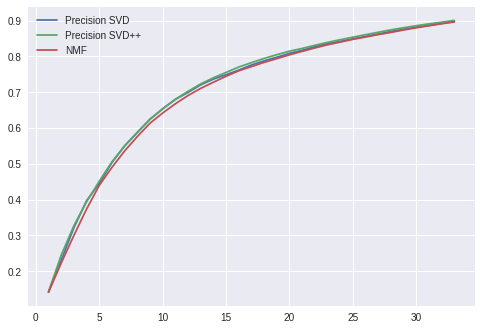

In [333]:
plt.plot(range(1,34), precisions_svd, label='Precision SVD')
plt.plot(range(1,34), precisions_pp, label='Precision SVD++')
plt.plot(range(1,34), precisions_nmf, label='NMF')

plt.legend()
plt.show()

In [336]:
arhr_nmf = []
for n in range(1, 34):
    top_n = get_top_n(predictions_nmf, n=n)
    arhr_nmf.append(evaluate_algo(arhr, trainset.all_users(), top_n, ideal_ranks, n))

In [337]:
arhr_pp = []
for n in range(1, 34):
    top_n = get_top_n(predictions_pp, n=n)
    arhr_pp.append(evaluate_algo(arhr, trainset.all_users(), top_n, ideal_ranks, n))

In [338]:
arhr_svd = []
for n in range(1, 34):
    top_n = get_top_n(predictions, n=n)
    arhr_svd.append(evaluate_algo(arhr, trainset.all_users(), top_n, ideal_ranks, n))

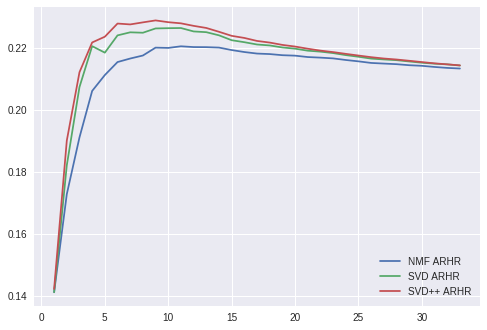

In [339]:
plt.plot(range(1,34), arhr_nmf, label='NMF ARHR')
plt.plot(range(1,34), arhr_svd, label='SVD ARHR')
plt.plot(range(1,34), arhr_pp, label='SVD++ ARHR')

plt.legend()
plt.show()

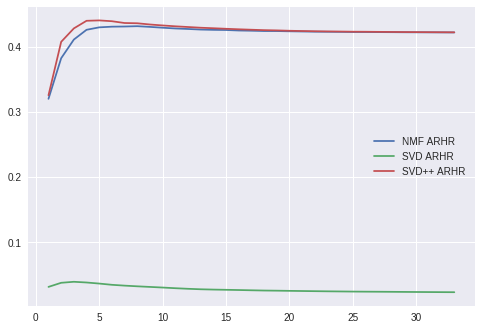

In [303]:
arhr_nmf = []
for n in range(1, 34):
    top_n = get_top_n(predictions_nmf, n=n)
    arhr_nmf.append(evaluate_algo(arhr, trainset.all_users(), top_n, ideal_ranks, n))
    
arhr_pp = []
for n in range(1, 34):
    top_n = get_top_n(predictions_pp, n=n)
    arhr_pp.append(evaluate_algo(arhr, trainset.all_users(), top_n, ideal_ranks, n))
    
arhr_svd = []
for n in range(1, 34):
    top_n = get_top_n(predictions, n=n)
    arhr_svd.append(evaluate_algo(arhr, trainset.all_users(), top_n, ideal_ranks, n))

plt.plot(range(1,34), arhr_nmf, label='NMF ARHR')
plt.plot(range(1,34), arhr_svd, label='SVD ARHR')
plt.plot(range(1,34), arhr_pp, label='SVD++ ARHR')

plt.legend()
plt.show()

In [168]:
def true_positives(ranking, ideal_ranking):
    tp = 0
    for p in ranking:
        if p in ideal_ranking:
            tp += 1
    return tp

def false_positives(ranking, ideal_ranking):
    fp = 0
    for p in ranking:
        if p not in ideal_ranking:
            fp += 1
    return fp

def false_negatives(ranking, ideal_ranking):
    fn = 0
    for p in ideal_ranking:
        if p not in ranking:
            fn += 1
    return fn

def precision(ranking, ideal_ranking):
    ranked_items = get_items(ranking)
    ideal_items = get_items(ideal_ranking)
    
    tp = true_positives(ranked_items, ideal_items)
    fp = false_positives(ranked_items, ideal_items)
    
    return tp / len(ranking)

def recall(ranking, ideal_ranking):
    ranked_items = get_items(ranking)
    ideal_items = get_items(ideal_ranking)
    
    tp = true_positives(ranked_items, ideal_items)
    fn = false_negatives(ranked_items, ideal_items)
    
    return tp / (tp + fn)

def get_items(ranking):
    return list(map(lambda t: t[0], ranking))

In [277]:
def arhr(ranking, ideal_ranking):
    p = 1
    arhr = 0
    
    ranked_items = get_items(ranking)
    ideal_items = get_items(ideal_ranking)
    
    for r in ranked_items:
        if r in ideal_items:
            arhr += 1 / p
        p += 1
        
    return arhr / (p - 1)

In [279]:
arhr([(1,0),(3,0),(4,0)], [(1,0),(2,0),(3,0)])

0.5

In [280]:
arhr([(1,0),(3,0),(4,0)], [(1,0),(4,0),(3,0)])

0.611111111111111

In [281]:
11/18

0.6111111111111112

In [103]:
def ideal_rankings(testset):
    rankings = defaultdict(list)

    for u_id, item_id, score in testset:
        rankings[u_id].append((item_id, score))
        
    for u_id in rankings.keys():
        rankings[u_id] = sorted(rankings[u_id], key=lambda t: t[1], reverse=True)
        
    return rankings

In [115]:
get_items(ideal_ranks['430'])

['56', '258', '514', '50', '1007', '148']

In [56]:
ideal_rankings['196']

[('302', 3.5298600000000002),
 ('377', 3.5298600000000002),
 ('51', 3.5298600000000002),
 ('346', 3.5298600000000002),
 ('474', 3.5298600000000002),
 ('265', 3.5298600000000002),
 ('465', 3.5298600000000002),
 ('451', 3.5298600000000002),
 ('86', 3.5298600000000002),
 ('1014', 3.5298600000000002),
 ('222', 3.5298600000000002),
 ('40', 3.5298600000000002),
 ('29', 3.5298600000000002),
 ('785', 3.5298600000000002),
 ('387', 3.5298600000000002),
 ('274', 3.5298600000000002),
 ('1042', 3.5298600000000002),
 ('1184', 3.5298600000000002),
 ('392', 3.5298600000000002),
 ('486', 3.5298600000000002),
 ('144', 3.5298600000000002),
 ('118', 3.5298600000000002),
 ('1', 3.5298600000000002),
 ('546', 3.5298600000000002),
 ('95', 3.5298600000000002),
 ('768', 3.5298600000000002),
 ('277', 3.5298600000000002),
 ('234', 3.5298600000000002),
 ('246', 3.5298600000000002),
 ('98', 3.5298600000000002),
 ('193', 3.5298600000000002),
 ('88', 3.5298600000000002),
 ('194', 3.5298600000000002),
 ('1081', 3.5298

In [73]:
trainset.knows_item('95')

False

In [76]:
# Load the full dataset.
data = Dataset.load_builtin('ml-100k')
raw_ratings = data.raw_ratings

# shuffle ratings if you want
random.shuffle(raw_ratings)

# A = 90% of the data, B = 10% of the data
threshold = int(.9 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = A_raw_ratings  # data is now the set A

In [78]:
testset = data.construct_testset(B_raw_ratings)

In [82]:
testset

[('664', '778', 3.0),
 ('62', '180', 4.0),
 ('86', '242', 4.0),
 ('748', '86', 4.0),
 ('7', '185', 5.0),
 ('758', '750', 2.0),
 ('654', '252', 2.0),
 ('894', '287', 4.0),
 ('104', '1028', 2.0),
 ('323', '678', 2.0),
 ('804', '1177', 3.0),
 ('537', '955', 4.0),
 ('385', '183', 3.0),
 ('643', '501', 4.0),
 ('887', '82', 4.0),
 ('587', '995', 3.0),
 ('178', '131', 4.0),
 ('864', '133', 5.0),
 ('871', '1385', 3.0),
 ('13', '370', 1.0),
 ('316', '199', 3.0),
 ('236', '225', 3.0),
 ('470', '919', 3.0),
 ('504', '181', 3.0),
 ('346', '38', 3.0),
 ('226', '508', 4.0),
 ('344', '118', 3.0),
 ('807', '636', 4.0),
 ('299', '514', 5.0),
 ('254', '225', 3.0),
 ('559', '587', 4.0),
 ('312', '921', 5.0),
 ('262', '70', 4.0),
 ('64', '311', 2.0),
 ('94', '423', 4.0),
 ('666', '319', 4.0),
 ('181', '1114', 1.0),
 ('660', '1', 3.0),
 ('533', '228', 4.0),
 ('725', '873', 4.0),
 ('788', '657', 4.0),
 ('207', '526', 4.0),
 ('422', '137', 5.0),
 ('911', '465', 5.0),
 ('262', '275', 4.0),
 ('715', '2', 3.0),